# 2D straight crack problem under remote uniform tension - Griffith crack problem


Plane Elasticity problem 
Straight fracture in an infinite isotropic elastic medium  under uniform remote tension

We explore the convergence as we refine the mesh for both 2DP0 and 2DP1 elements.

In [1]:
# imports etc.
import sys
import os
home = os.environ["HOME"]
sys.path.append("/Users/bricelecampion/ClionProjects/BigWham_dev/build/interfaces/python")
from hmatrix import Hmatrix
import numpy as np
from scipy.sparse.linalg import gmres

sys.path.append(os.path.join(os.getcwd(), '../..'))
from solutions.griffith_crack import width_griffith
import matplotlib.pyplot as plt


We set the elastic properties of the medium. Note that bigwham's input are the Young's modulus $E$ and Poisson's ratio $\nu$.

In [2]:
G = 1.0
nu = 0.25
E = (2 * G) * (1 + nu)

We define a function in order to solve the problem with a given number of elements. Either for P0 elements (constant displacement interpolation) or P1 elements (linear interpolation over the element but discontinuous between element).

In [6]:
def solveGriffith(nelts,a=1,kernel = "2DP0"):
    """Wrapper function to solve the Griffith problem with a given number of elements + element type"""
    coor1D = np.linspace(-a, a, nelts + 1)
    coor = np.transpose(np.array([coor1D, coor1D * 0.0]))
    conn = np.fromfunction(lambda i, j: i + j, (nelts, 2), dtype=np.int_)
    # H-matrix parameters - choosen here to have an accurate solution
    max_leaf_size=100
    eta=2.
    eps_aca=1.e-5
    elas_prop = np.array([E, nu])
    h = Hmatrix(kernel, coor, conn, elas_prop, max_leaf_size, eta, eps_aca)
    t = np.ones(h.shape[0])
    t[0::2] = 0.
    jac_ilu= h.H_ILU_prec() # we use a ILU decomposition of the full block for efficient solution via gmres
    d = gmres(h, t,M=jac_ilu,tol=1e-6)[0]
    dd = d.reshape((-1, 2))
    col_pts = h.getMeshCollocationPoints()
    x_coor_=col_pts[:,0]
    # Crack opening displacement discontinuity from analytical solution 
    # note that 2DP1 segment have their solution at nodes.... 
    # note that 2DP1 segment have displacement disconinuity at element vertex for each element
    if (kernel =="2DP1"):
        x_coor_ = np.ones(2*nelts)
        for e in range(nelts):
            x_coor_[e*2:e*2+2]=coor1D[conn[e]]
    w_true=width_griffith(x_coor_,a=1,sig=1,G=1,nu=0.25)
    rmse = np.sqrt((np.sum(dd[:,1]-w_true)**2)/(w_true.size))
    l2rel = (np.linalg.norm((dd[:,1]-w_true)))/(np.linalg.norm(w_true))
    return x_coor_,dd,w_true,rmse,l2rel 

## Piece-wise constant interpolation element

Let's first look at the solution for P0 element, using 30 elements. We see that the numerical solution estimate of the fracture width is sligthly larger than the true solution. This is typical for this type of boundary element (see Crouch & Starfield - chapter 5).

0.033981461904354915


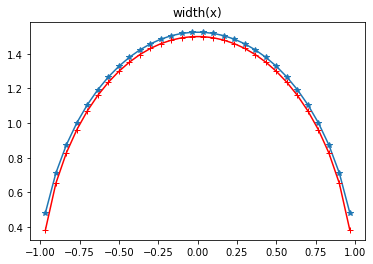

In [7]:
xcorr,dd_sol,w_true,rmse,l2rel = solveGriffith(30,a=1,kernel="2DP0")

plt.plot(xcorr, dd_sol[:,1], "-*")
plt.plot(xcorr, w_true, "-+r") 
plt.title('width(x)')
print(l2rel)

Now, let's perform the same numerical simulation for different number of elements. We go from 10 elements to 10'000. We compute the "approximate" rate of convergence of both the rmse and l2 relative error.
Note that the RMSE and relative L2 norm are defined respetively as
 $$rmse = \sqrt{\sum_{i=1,N} (num_i - true_i)^2/N} $$
 and
 $$L_{2 rel} = \frac{\||  \mathbf{num} - \mathbf{true} \||_2}{\|| \mathbf{true} \||_2}$$
  such that the rate of convergence of the rmse is about 1/2 of the one of the L2.

To esitmate the rate of convernce of an error metric $e$, we compute:
$$ \beta = \log{(e_2/e_1)}/\log{(N_1/N_2)} $$

where $e_1$ is the error for $N_1$ unknowns, respectively for $e_2$ (with $N_2<N_1$). 

In [17]:
list_nelts=np.array([10,20,50,100,200,500,1000,2000,5000,10000])
rmse =[]
l2_rel = []
for n in list_nelts:
    col_pts,dd_sol,wtr,rmse_n,lerel_n = solveGriffith(n,a=1,kernel="2DP0")
    rmse.append(rmse_n)
    l2_rel.append(lerel_n)
    
# computing the rate of convergence
beta_rmse = [1 * np.log(rmse[i]/rmse[i-1])/np.log(list_nelts[i-1]/list_nelts[i]) for i in range(2,list_nelts.size-1)]
beta_l2 = [1 * np.log(l2_rel[i]/l2_rel[i-1])/np.log(list_nelts[i-1]/list_nelts[i]) for i in range(2,list_nelts.size-1)]

0.49105258607754493


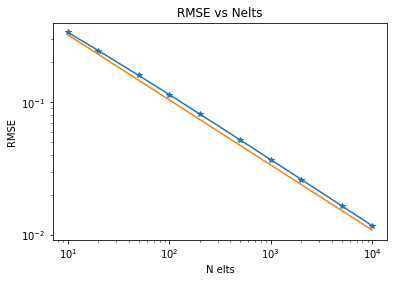

In [20]:
plt.loglog(list_nelts, rmse, "-*")
plt.loglog(list_nelts, 1/list_nelts**np.median(beta_rmse), "-")
plt.title('RMSE vs Nelts')
plt.xlabel('N elts')
plt.ylabel('RMSE')
print(np.median(beta_rmse))
# rmese defined as  sqrt(1/Nelts Sum  (num_i-true_i)^2)

0.9366792409801439


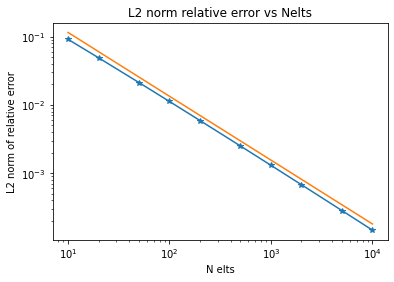

In [22]:
plt.loglog(list_nelts, l2_rel, "-*")
plt.loglog(list_nelts, 1/list_nelts**np.median(beta_l2), "-")
plt.title('L2 norm relative error vs Nelts')
plt.xlabel('N elts')
plt.ylabel('L2 norm of relative error')
# L2 norm relative defined as ||num_i - true_i||_2 / ||true_i||
print(np.median(beta_l2))


## Piece-wise linear element

We now move to the case of piece-wise element. First doing a simulation with N=10 elements such that we can 'compare' with the solution obtained with 20 P0 elements. Because it's fast we recompute here the P0 solution too. Except at the tip, the solution with P1 elements is much more accurate than the P0 element for the same number of degree of freedoms !

0.24528690732913772
0.12956859610420834


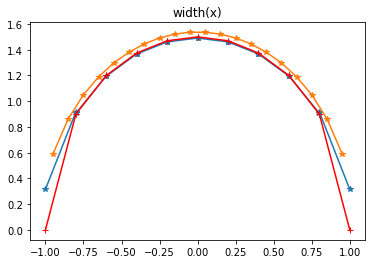

In [23]:
x_corr_P0,dd_sol_P0,w_true_P0,rmse_P0,l2rel_P0 = solveGriffith(20,a=1,kernel="2DP0")
x_corr_P1,dd_sol_P1,w_true_P1,rmse_P1,l2rel_P1 = solveGriffith(10,a=1,kernel="2DP1")

plt.plot(x_corr_P1, dd_sol_P1[:,1], "-*")
plt.plot(x_corr_P0, dd_sol_P0[:,1], "-*")
plt.plot(x_corr_P1, w_true_P1, "-+r") 
plt.title('width(x)')

print(rmse_P0)
print(rmse_P1)

We now turn to explore the convergence rate for P1 elements. Keep in minf that here the number of dof is twice the number of elements !

In [24]:
list_nelts=np.array([10,20,50,100,200,500,1000,2000,5000,10000])
rmse =[]
l2_rel = []
for n in list_nelts:
    col_pts,dd_sol,wtr,rmse_n,lerel_n = solveGriffith(n,a=1,kernel="2DP1")
    rmse.append(rmse_n)
    l2_rel.append(lerel_n)
    
# computing the rate of convergence
beta_rmse = [1 * np.log(rmse[i]/rmse[i-1])/np.log(list_nelts[i-1]/list_nelts[i]) for i in range(2,list_nelts.size-1)]
beta_l2 = [1 * np.log(l2_rel[i]/l2_rel[i-1])/np.log(list_nelts[i-1]/list_nelts[i]) for i in range(2,list_nelts.size-1)]

the convergence on the RMSE is smaller than for P0 -  exhibiting an  drop early on (so we exclude the first few points for the estimate of the convergence rate). Note however, than the values are lower than the P0 for the same number of dofs.

0.3071799174049076


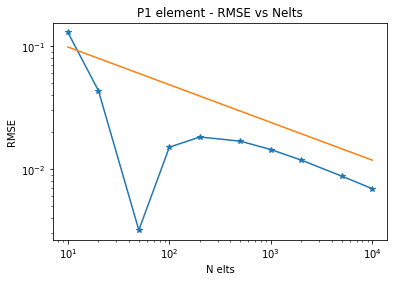

In [25]:
plt.loglog(list_nelts, rmse, "-*")
plt.loglog(list_nelts, 0.2/list_nelts**np.median(beta_rmse[5::]), "-")
plt.title('P1 element - RMSE vs Nelts')
plt.xlabel('N elts')
plt.ylabel('RMSE')
print(np.median(beta_rmse[5::]))

The convergence of the L2 norm is "cleaner" and exhibit the same rate than for P0 element. However, again, the error is "consistently" smaller for the same number of dofs.

0.9827690224038516


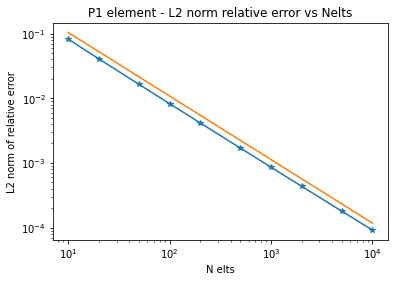

In [26]:
plt.loglog(list_nelts, l2_rel, "-*")
plt.loglog(list_nelts, 1/list_nelts**np.median(beta_l2), "-")
plt.title('P1 element - L2 norm relative error vs Nelts')
plt.xlabel('N elts')
plt.ylabel('L2 norm of relative error')
# L2 norm relative defined as ||num_i - true_i||_2 / ||true_i||
print(np.median(beta_l2))